In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

import os
import multiprocessing as mp
from tqdm import tqdm
import time

# For feature extraction: discrete wavelet transform
import pywt

# For CNN
import torch
import torch.nn
import torch.optim
from torch.utils.data import TensorDataset, DataLoader
from torch.nn.functional import softmax

### Reading images

In [2]:
with open("./train.txt") as f:
    train_file_list = f.readlines()
with open("./val.txt") as f:
    val_file_list = f.readlines()
with open("./test.txt") as f:
    test_file_list = f.readlines()

train_file_list = [x.strip().split(sep=" ") for x in train_file_list]
val_file_list = [x.strip().split(sep=" ") for x in val_file_list]
test_file_list = [x.strip().split(sep=" ") for x in test_file_list]

train_label = [int(x[1]) for x in train_file_list]
val_label = [int(x[1]) for x in val_file_list]
test_label = [int(x[1]) for x in test_file_list]

train_file_list = [x[0] for x in train_file_list]
val_file_list = [x[0] for x in val_file_list]
test_file_list = [x[0] for x in test_file_list]

In [3]:
print("# cpus: ", os.cpu_count())
NUM_PROCESSES = 8

# cpus:  64


In [4]:
def ReadImage(filePath):
    # image = cv2.imread(filePath, cv2.IMREAD_COLOR)
    image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
    # image = cv2.resize(image, (256, 256))
    return image

In [5]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_imgs = pool.map(ReadImage, tqdm(train_file_list))
    val_imgs = pool.map(ReadImage, tqdm(val_file_list))
    test_imgs = pool.map(ReadImage, tqdm(test_file_list))

100%|██████████| 450/450 [00:00<00:00, 282635.04it/s]


In [6]:
# resize the images to 256x256
def ResizeImage(image):
    # resized_img = cv2.resize(image, (256, 256))
    resized_img = cv2.resize(image, (128, 128))
    return resized_img

In [7]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    resized_train_imgs = pool.map(ResizeImage, tqdm(train_imgs))
    resized_val_imgs = pool.map(ResizeImage, tqdm(val_imgs))
    resized_test_imgs = pool.map(ResizeImage, tqdm(test_imgs))

100%|██████████| 450/450 [00:00<00:00, 4787.61it/s]


### DWT

In [42]:
# Discrete Wavelet Transform
def WaveletTransform(image):
    coeffs = pywt.dwt2(data=image, wavelet='haar', mode='symmetric', axes=(0, 1))
    # cA, (cH, cV, cD) = coeffs
    _, (cH, cV, cD) = coeffs
    # cA, _ = coeffs
    # _, (cH, cV, _) = coeffs
    # _, (cH, _, _) = coeffs
    return np.array([[cH], [cV], [cD]]).squeeze()

In [43]:
with mp.Pool(processes=NUM_PROCESSES) as pool:
    train_features = pool.map(WaveletTransform, tqdm(resized_train_imgs))
    val_features = pool.map(WaveletTransform, tqdm(resized_val_imgs))
    test_features = pool.map(WaveletTransform, tqdm(resized_test_imgs))

# train_features = np.array(train_features).squeeze()
# val_features = np.array(val_features).squeeze()
# test_features = np.array(test_features).squeeze()

train_features = np.array(train_features)
val_features = np.array(val_features)
test_features = np.array(test_features)

100%|██████████| 450/450 [00:00<00:00, 2303.11it/s]


In [44]:
train_features.shape

(63325, 3, 64, 64)

### CNN

In [45]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [46]:
print(train_features.shape)
print(len(train_label))

(63325, 3, 64, 64)
63325


In [47]:
# prepare dataloader
BATCH_SIZE = 32
IMG_W, IMG_H = 64, 64

train_features = torch.FloatTensor(train_features)
val_features = torch.FloatTensor(val_features)
test_features = torch.FloatTensor(test_features)
train_label = torch.IntTensor(train_label)
val_label = torch.IntTensor(val_label)
test_label = torch.IntTensor(test_label)

train_dataset = TensorDataset(train_features, train_label)
val_dataset = TensorDataset(val_features, val_label)
test_dataset = TensorDataset(test_features, test_label)

train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)
test_dataloader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_PROCESSES
)

In [48]:
class CNN(torch.nn.Module):  # input_shape: (32, 3, 64, 64)
    def __init__(self, num_classes) -> None:
        super(CNN, self).__init__()
        # 1
        self.conv1 = torch.nn.Conv2d(
            in_channels=3,
            out_channels=16,
            kernel_size=3,
            stride=1,
            padding=1
        )  # (-1, 16, 62, 62)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # (16, 32, 32)
        self.batchnorm1 = torch.nn.BatchNorm2d(num_features=16)
        # 2
        self.conv2 = torch.nn.Conv2d(
            in_channels=16,
            out_channels=32,
            kernel_size=3,
            stride=1,
            padding=1
        )  # (32, 32, 32)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # (32, 16, 16)
        self.batchnorm2 = torch.nn.BatchNorm2d(num_features=32)
        # 3
        self.conv3 = torch.nn.Conv2d(
            in_channels=32,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )  # (64, 17, 17)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )  # (64, 8, 8)
        self.batchnorm3 = torch.nn.BatchNorm2d(num_features=64)
        # 4
        self.fc1 = torch.nn.Linear(
            in_features=64 * 8 * 8,
            out_features=128
        )
        self.relu4 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(
            in_features=128,
            out_features=num_classes
        )

    def forward(self, x):
        x = self.batchnorm1(self.pool1(self.relu1(self.conv1(x))))
        x = self.batchnorm2(self.pool2(self.relu2(self.conv2(x))))
        x = self.batchnorm3(self.pool3(self.relu3(self.conv3(x))))
        x = x.view(-1, 64 * 8 * 8)
        x = self.relu4(self.fc1(x))
        x = self.fc2(x)
        return x


### Top-1 Accuracy

In [49]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [68]:
model = CNN(num_classes=50).to(device)
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

torch.manual_seed(42)
EPOCH = 30
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(EPOCH):
    # print(f"Epoch: {epoch + 1}")
    ### training
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader, start=1):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.argmax(softmax(y_logit, dim=1), dim=1) # top-1
        loss = loss_fcn(y_logit, y.to(torch.int64))
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if batch % 400 == 0:
            # print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
        
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    ### validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logit = model(X)
            val_pred = torch.argmax(softmax(val_logit, dim=1), dim=1)

            val_loss += loss_fcn(val_logit, y.to(torch.int64))
            val_acc += accuracy_fn(y, val_pred)

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

Train loss: 3.75522, Train acc: 5.50% | Validation loss: 3.69623, Validation acc: 7.29%
Train loss: 3.54943, Train acc: 9.52% | Validation loss: 3.44280, Validation acc: 12.29%
Train loss: 3.41215, Train acc: 12.33% | Validation loss: 3.40560, Validation acc: 11.46%
Train loss: 3.28716, Train acc: 14.72% | Validation loss: 3.32731, Validation acc: 12.92%
Train loss: 3.18535, Train acc: 16.60% | Validation loss: 3.25184, Validation acc: 13.54%
Train loss: 3.10355, Train acc: 18.31% | Validation loss: 3.13563, Validation acc: 20.42%
Train loss: 3.03382, Train acc: 19.88% | Validation loss: 3.03925, Validation acc: 18.75%
Train loss: 2.96808, Train acc: 21.27% | Validation loss: 3.07207, Validation acc: 18.54%
Train loss: 2.90568, Train acc: 22.81% | Validation loss: 3.03280, Validation acc: 19.79%
Train loss: 2.84978, Train acc: 24.08% | Validation loss: 2.88424, Validation acc: 22.50%
Train loss: 2.79496, Train acc: 25.56% | Validation loss: 3.00303, Validation acc: 18.54%
Train loss: 2

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f5853de04e0>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1295, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


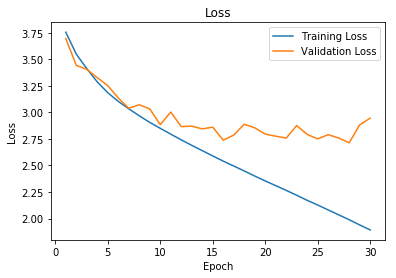

In [69]:
plt.plot(range(1, EPOCH+1), train_loss_list, label='Training Loss')
plt.plot(range(1, EPOCH+1), val_loss_list, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

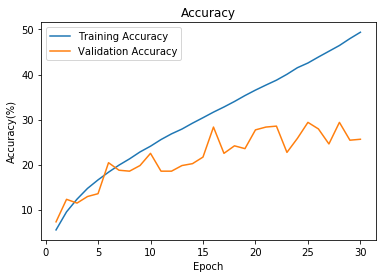

In [70]:
plt.plot(range(1, EPOCH+1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, EPOCH+1), val_acc_list, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()

### Top-5 Accuracy

In [71]:
def ComputeTop5Acc(y_logit, y):
    y_prob = softmax(y_logit, dim=1)
    y_pred_top5 = y_prob.argsort(axis=1)[:, -5:]
    y_true_in_top5 = [y[i] in y_pred_top5[i] for i in range(len(y))]
    
    return (sum(np.array(y_true_in_top5) == np.array([True]*len(y))) / len(y)) * 100

In [72]:
model = CNN(num_classes=50).to(device)
loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9)
# optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)

torch.manual_seed(42)
EPOCH = 30
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
for epoch in range(EPOCH):
    # print(f"Epoch: {epoch + 1}")
    ### training
    model.train()
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(train_dataloader, start=1):
        X, y = X.to(device), y.to(device)
        y_logit = model(X)
        y_pred = torch.argmax(softmax(y_logit, dim=1), dim=1) # top-1
        loss = loss_fcn(y_logit, y.to(torch.int64))
        train_loss += loss
        train_acc += ComputeTop5Acc(y_logit, y)  # top-5

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # if batch % 400 == 0:
            # print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    
    train_loss /= len(train_dataloader)
    train_acc /= len(train_dataloader)
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    ### validation
    model.eval()
    val_loss, val_acc = 0, 0
    with torch.inference_mode():
        for X, y in val_dataloader:
            X, y = X.to(device), y.to(device)
            val_logit = model(X)
            val_pred = torch.argmax(softmax(val_logit, dim=1), dim=1)

            val_loss += loss_fcn(val_logit, y.to(torch.int64))
            val_acc += ComputeTop5Acc(val_logit, y)

        val_loss /= len(val_dataloader)
        val_acc /= len(val_dataloader)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

    print(f"Train loss: {train_loss:.5f}, Train acc: {train_acc:.2f}% | Validation loss: {val_loss:.5f}, Validation acc: {val_acc:.2f}%")

Train loss: 3.74548, Train acc: 22.61% | Validation loss: 3.66368, Validation acc: 26.67%
Train loss: 3.53807, Train acc: 32.36% | Validation loss: 3.41717, Validation acc: 34.79%
Train loss: 3.39824, Train acc: 38.53% | Validation loss: 3.37814, Validation acc: 39.38%
Train loss: 3.27973, Train acc: 42.87% | Validation loss: 3.30679, Validation acc: 39.38%
Train loss: 3.18504, Train acc: 45.86% | Validation loss: 3.24420, Validation acc: 44.58%
Train loss: 3.10689, Train acc: 48.39% | Validation loss: 3.16172, Validation acc: 46.88%
Train loss: 3.04092, Train acc: 50.64% | Validation loss: 3.02986, Validation acc: 52.29%
Train loss: 2.97925, Train acc: 52.64% | Validation loss: 3.08219, Validation acc: 46.04%
Train loss: 2.91792, Train acc: 54.52% | Validation loss: 3.03000, Validation acc: 50.42%
Train loss: 2.86122, Train acc: 56.39% | Validation loss: 2.88241, Validation acc: 55.00%
Train loss: 2.80552, Train acc: 58.02% | Validation loss: 2.95451, Validation acc: 53.75%
Train loss

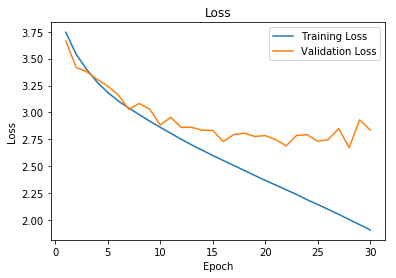

In [73]:
plt.plot(range(1, EPOCH+1), train_loss_list, label='Training Loss')
plt.plot(range(1, EPOCH+1), val_loss_list, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

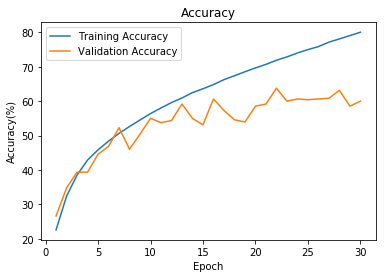

In [74]:
plt.plot(range(1, EPOCH+1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, EPOCH+1), val_acc_list, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy(%)')
plt.legend()
plt.show()